In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pandas_summary import DataFrameSummary
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [2]:
DATA        = Path('data')
RAW         = DATA/'raw'
INTERIM     = DATA/'interim'
PROCESSED   = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [5]:
challenge  = pd.read_csv(RAW/'Challenge_20180423.csv', low_memory=False)
customer   = pd.read_csv(RAW/'Customer.csv', low_memory=False)
isin       = pd.read_csv(RAW/'Isin.csv', low_memory=False)
market     = pd.read_csv(RAW/'Market.csv', low_memory=False)
macro      = pd.read_csv(RAW/'MarketData_Macro.csv', low_memory=False)
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
trade      = pd.read_csv(RAW/'Trade.csv', low_memory=False)

In [4]:
isin.sample(5)

,IsinIdx,TickerIdx,ActualMaturityDateKey,IssueDateKey,Seniority,Currency,ActivityGroup,Region,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType
24643,24643,2396,20260615,20160615,GOV,USD,FLOW LOCAL MARKET,EUROPE,LOCAL MARKET,LOCAL MARKET,EUROPE LM SK,BB+,Government,Sovereign,Euro-dollar,2.500000e+09,FIXED
10545,10545,2573,20431115,20131114,SEN,USD,FLOW G10,AMERICAS,HG CASH,HG CASH NONFIN,US ENERGY CASH,A,Utilities,Electric-Integrated,US domestic,2.500000e+08,FIXED
23998,23998,2829,20181009,20151009,SEN,EUR,FLOW G10,EUROPE,INSTITUTIONAL MARKET MAKING,FINANCIALS,SNR FINS,A+,Financial,Special Purpose Banks,Euro mtn,1.500000e+09,FIXED
485,485,722,20190910,20090910,SEC,CHF,SAS & COVERED BONDS,CHF SAS,SAS CHF,CHF SAS,CHF SAS,AAA,Financial,Mortgage Banks,Euro mtn,2.500000e+08,FIXED
11419,11419,2184,20420915,20120913,SEN,USD,FLOW G10,AMERICAS,HG CASH,HG CASH NONFIN,US NONFIN 5Y AND IN CASH,AA-,"Consumer, Non-cyclic",Medical-Drugs,Global,5.000000e+08,FIXED


In [8]:
market.DateKey.max()

20180420

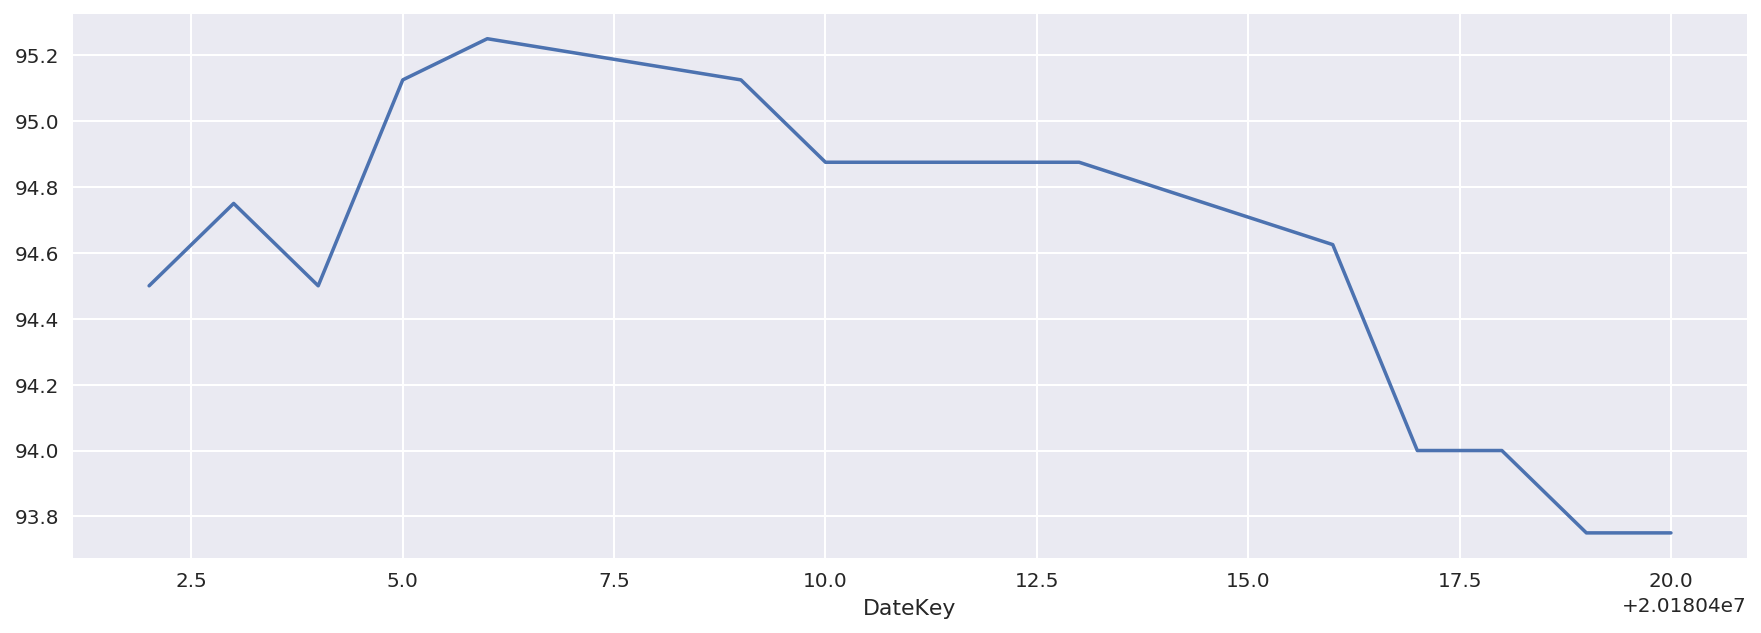

In [21]:
market[(market.IsinIdx == 24643) & (market.DateKey > 20180400)].set_index('DateKey').Price.plot(figsize=(15,5))

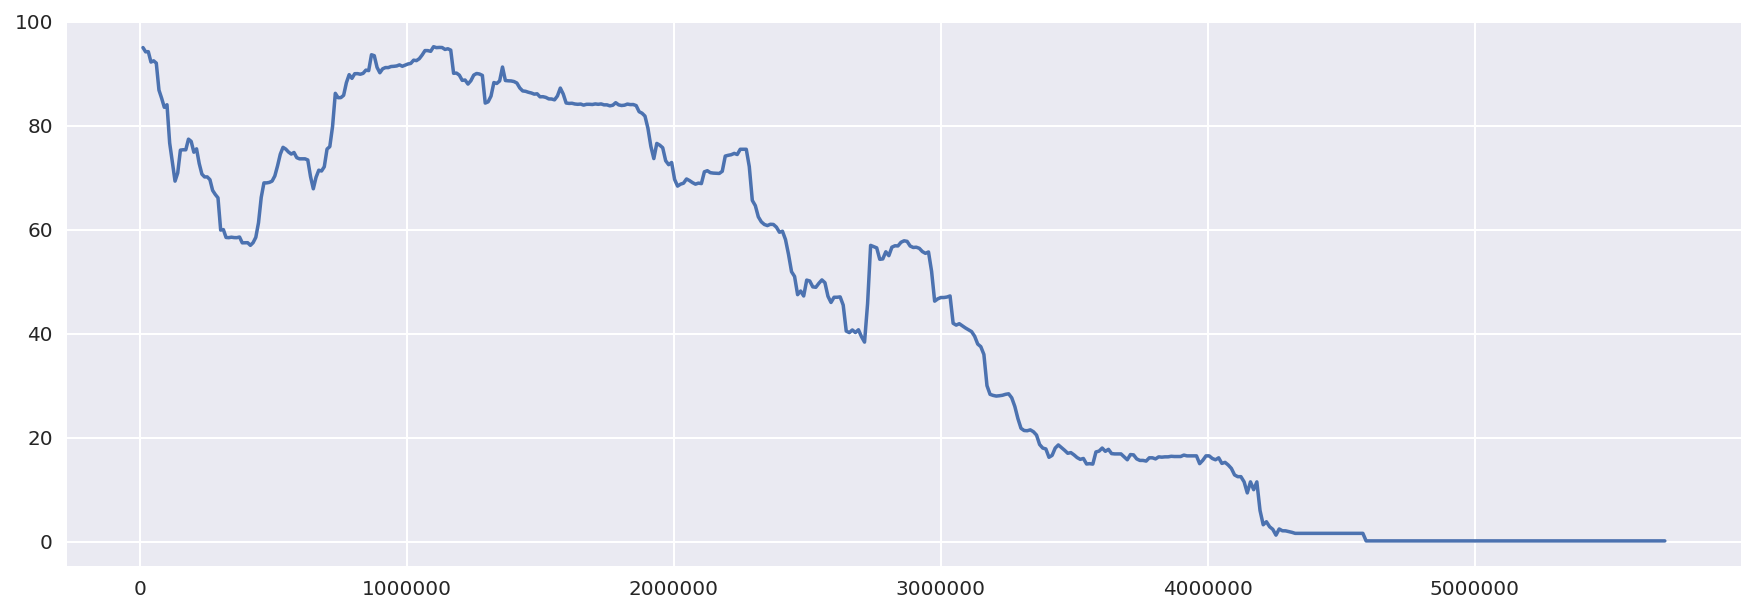

In [100]:
market[(market.IsinIdx == 24185)].Price.plot(figsize=(15,5))

In [40]:
from datetime import date, timedelta
d1 = date(2016, 1, 1)  
d2 = date(2018, 5, 1)  
delta = d2 - d1        
valid_days = [int(str(d1 + timedelta(i)).replace('-', '')) for i in range(delta.days + 1)]

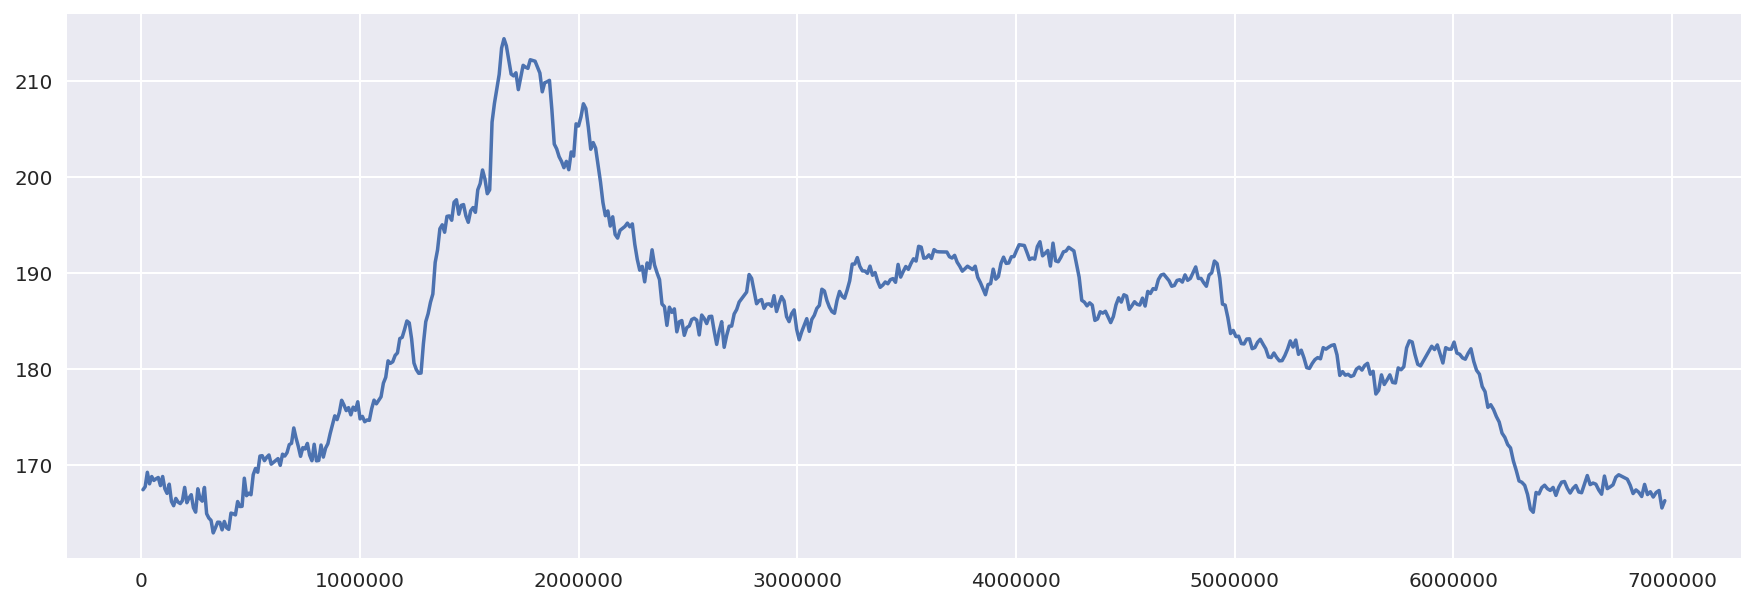

In [99]:
market[(market.IsinIdx == 19025)].Price.plot(figsize=(15,5))

In [32]:
market[market.Price==214.44]

,IsinIdx,DateKey,Price,Yield,ZSpread
1658761,19025,20160811,214.44,1.77,0.935


In [42]:
market[['Price', 'Yield', 'ZSpread']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,9867747.0,105.473558,12.069646,0.150,100.225,103.002,108.476,2.144400e+02
Yield,9867747.0,18.827194,4072.348350,-11701.626,1.156,2.574,3.901,5.301371e+06
ZSpread,9867747.0,2120.734676,319792.058286,-248.413,0.293,0.931,1.937,1.411321e+08


## Group by week and average 

In [86]:
from src.utils import num2date, date2num, week_num, get_weeks

In [94]:
df = market[market.IsinIdx == 24643].copy()

In [87]:
weeks = get_weeks(20150105)

In [95]:
df['week'] = df.DateKey.apply(lambda x: week_num(weeks, x))

In [102]:
weekly_values = df.groupby('week')[['Price', 'Yield', 'ZSpread']].agg('mean')

In [110]:
week_num(weeks, 20180423)

172

In [113]:
df[df.week<=172].tail(10)

,IsinIdx,DateKey,Price,Yield,ZSpread,week
6850863,24643,20180409,95.125,5.497,2.718,170
6864036,24643,20180410,94.875,5.537,2.744,170
6877216,24643,20180411,94.875,5.537,2.744,170
6890409,24643,20180412,94.875,5.538,2.695,170
6903608,24643,20180413,94.875,5.538,2.700,170
6916809,24643,20180416,94.625,5.578,2.739,171
6930018,24643,20180417,94.000,5.678,2.853,171
6943233,24643,20180418,94.000,5.679,2.803,171
6956450,24643,20180419,93.750,5.720,2.808,171
6969666,24643,20180420,93.750,5.720,2.766,171


In [124]:
weekly_values[weekly_values<172].tail(10)

,Price,Yield,ZSpread
week,,,
162,95.5940,5.4136,2.5882
163,96.0850,5.3382,2.4786
164,96.2862,5.3088,2.4908
165,96.2074,5.3222,2.4712
166,96.0544,5.3470,2.5038
167,94.5866,5.5786,2.7178
168,94.1268,5.6532,2.8784
169,94.8250,5.5438,2.7640
170,94.9250,5.5294,2.7202


In [133]:
def get_previous_weeks(current_week, previous_weeks):
    weeks_idxs = [current_week - w_off for w_off in previous_weeks]
    return weekly_values.loc[current_week] - weekly_values.loc[weeks_idxs] 

In [134]:
get_previous_weeks(171, [1,2,4,8,16])

,Price,Yield,ZSpread
week,,,
170,-0.9000,0.1456,0.0736
169,-0.8000,0.1312,0.0298
167,-0.5616,0.0964,0.0760
163,-2.0600,0.3368,0.3152
155,-3.2460,0.5236,0.0098


In [126]:
get_previous_weeks(171, [1,2,4,8,16])

,Price,Yield,ZSpread
week,,,
170,94.9250,5.5294,2.7202
169,94.8250,5.5438,2.7640
167,94.5866,5.5786,2.7178
163,96.0850,5.3382,2.4786
155,97.2710,5.1514,2.7840


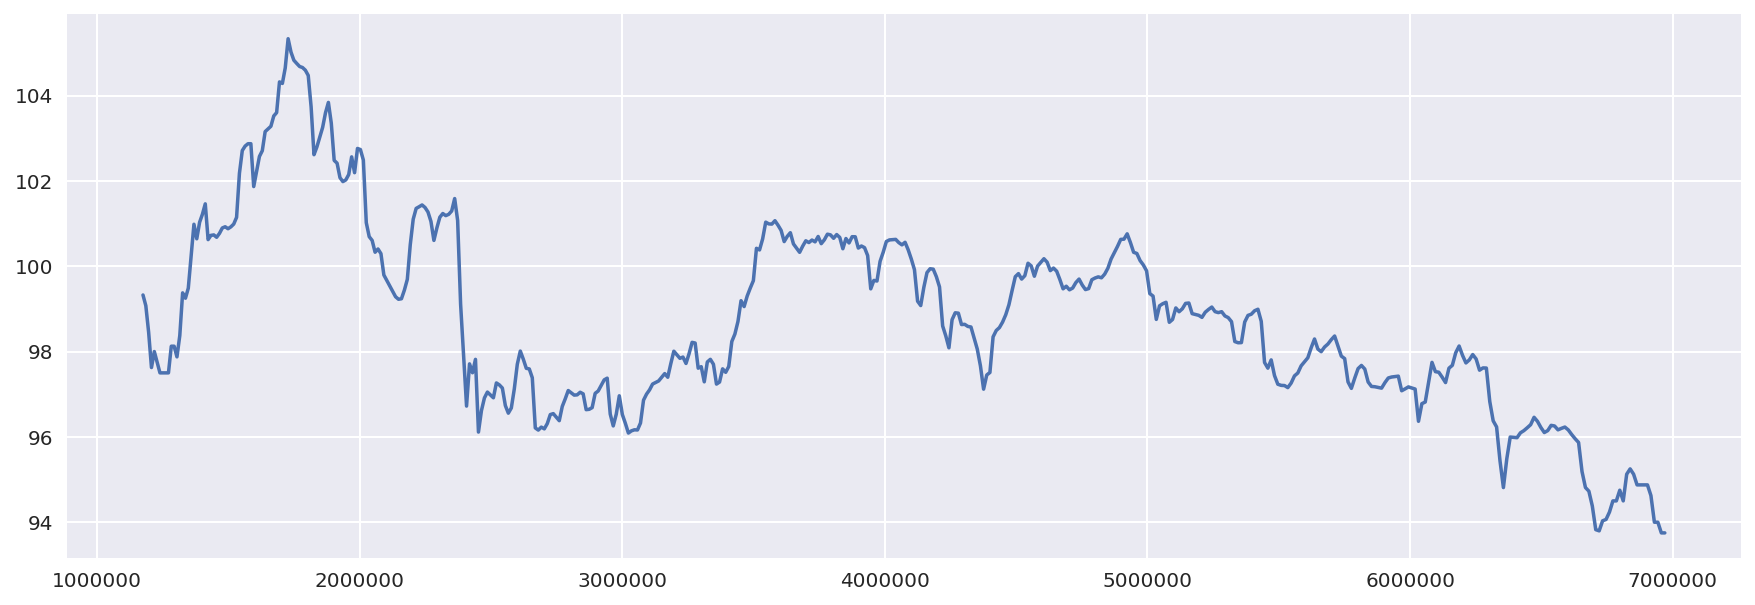

In [107]:
df.Price.plot(figsize=(15,5))

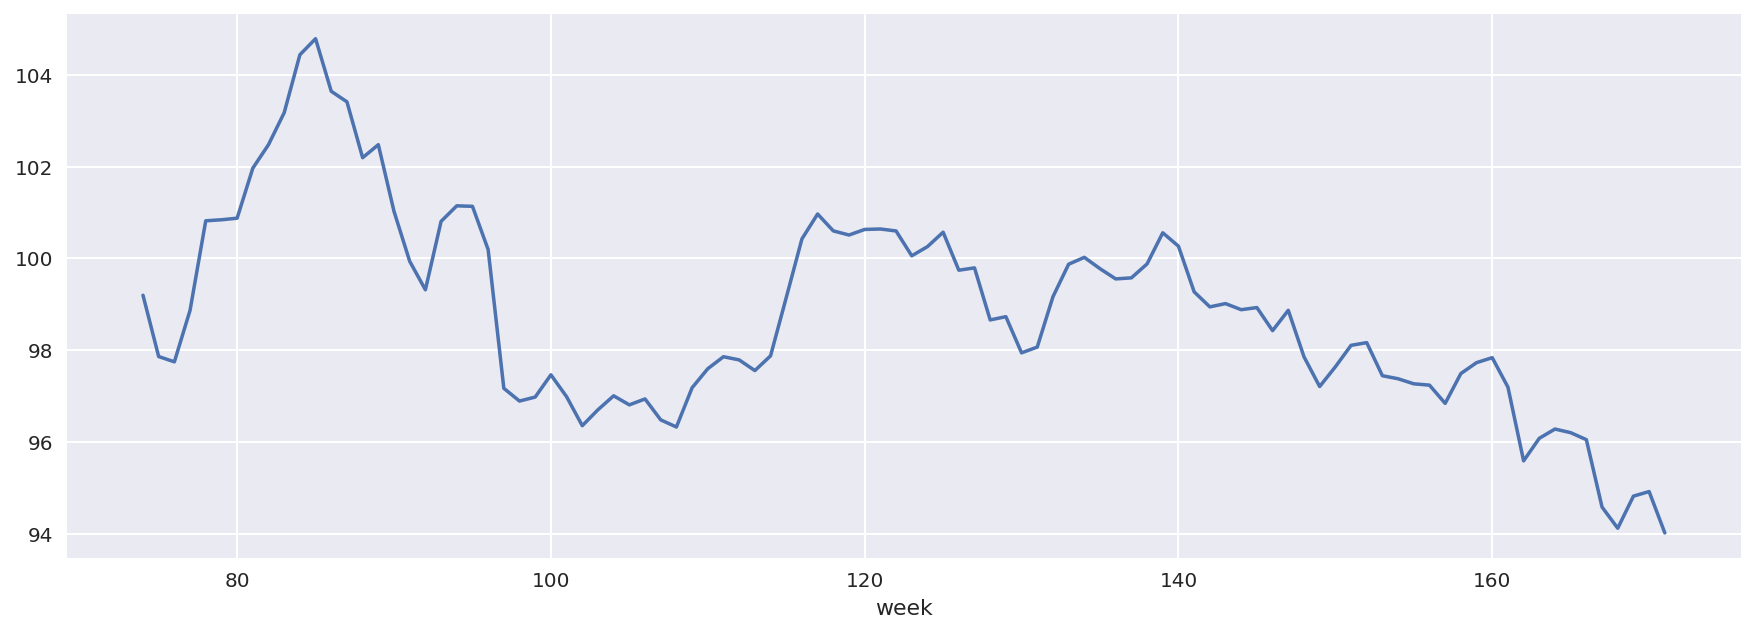

In [108]:
weekly_values.Price.plot(figsize=(15,5))

In [66]:
weeks[:10]

[20150105,
 20150112,
 20150119,
 20150126,
 20150202,
 20150209,
 20150216,
 20150223,
 20150302,
 20150309]

In [61]:
date2num(weeks[0])

20150105

In [55]:
num2date(20150105) + timedelta(7)

datetime.date(2015, 1, 12)

In [49]:
num2date(20160609)

datetime.date(2016, 6, 9)

In [44]:
df

,IsinIdx,DateKey,Price,Yield,ZSpread
1175520,24643,20160609,99.325,4.836,3.331
1186279,24643,20160610,99.075,4.868,3.400
1197043,24643,20160613,98.450,4.948,3.506
1207812,24643,20160614,97.625,5.056,3.618
1218587,24643,20160615,98.000,5.007,3.588
1229366,24643,20160616,97.750,5.039,3.653
1240148,24643,20160617,97.500,5.072,3.625
1250932,24643,20160620,97.500,5.072,3.574
1261716,24643,20160621,97.500,5.072,3.543
1272499,24643,20160622,97.500,5.072,3.557
